Data Analysis of OD-Measurment data. 
File-type - xslx, not CSV. 
Values are in a table

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
import re
from scipy import stats
import wx
import statistics
import json
import uuid
from functools import reduce


GUI for Plate layout, etc. 

In [3]:
blank = False
global blank_dict
blank_dict = {}
key_list = {}
nested_dict = {}
wells_clicked = []
blank_measurements = []
new_keys = []
media_selection = []
status_list = []
file_name = None
Evolved = None
global key_wells
key_wells = {}
global unique_key
unique_key = f"{uuid.uuid4()}"

user_input = pd.DataFrame(columns = ['Strain', 'Wells', 'Media', 'Status'])

class PlateFrame(wx.Frame):
    def __init__(self, parent, title, size=(800, 600)):
        super(PlateFrame, self).__init__(parent, title=title, size=size)
        self.CenterOnScreen(wx.BOTH)
        self.initUI()

    def initUI(self):
        panel = wx.Panel(self)
        main_sizer = wx.BoxSizer(wx.VERTICAL)

        # Strain ID input
        strain_sizer = wx.BoxSizer(wx.HORIZONTAL)
        strain_label = wx.StaticText(panel, label="Enter Bacterial Strain:")
        self.strain_text = wx.TextCtrl(panel, style=wx.TE_PROCESS_ENTER)
        strain_sizer.Add(strain_label, 0, wx.ALL | wx.ALIGN_CENTER_VERTICAL, 5)
        strain_sizer.Add(self.strain_text, 1, wx.EXPAND | wx.ALL, 5)

        #File path button
        self.file_button = wx.Button(panel, label = 'Raw-data file')
        main_sizer.Add(self.file_button, wx.ALIGN_CENTER_HORIZONTAL | wx.ALL, 5)
        self.file_button.Bind(wx.EVT_BUTTON, self.get_file_path)

        main_sizer.Add((-1, 10))

        #Add evolved / non evolved Checkmark:
        status_selection = ['Evolved', 'Non-evolved', 'BLANK']
        self.status_button = wx.ComboBox(panel, choices = status_selection, style = wx.CB_DROPDOWN)
        main_sizer.Add(self.status_button, 0, wx.EXPAND|wx.ALL, 10)

        #Add media selection --> Drop down with pre selection or new entry
        media_selection = ['AAM + HFD', 'AAM + CHOW', 'Caecum Media', 'Standard AAM']
        self.media_button = wx.ComboBox(panel, choices = media_selection, style = wx.CB_DROPDOWN)
        self.media_button.Bind(wx.EVT_COMBOBOX, self.on_media_selection)
        main_sizer.Add(self.media_button, 0, wx.EXPAND|wx.ALL, 10)

        #Add Incoulation time button
        inoc_time = ['24h inoculation', 'Diet change inoculation']
        self.inoc_button = wx.ComboBox(panel, choices = inoc_time, style = wx.CB_DROPDOWN)
        main_sizer.Add(self.inoc_button, 0, wx.EXPAND|wx.ALL, 10)

        # Add Strain-Well button
        self.add_button = wx.Button(panel, label='Add Strain-Well')
        strain_sizer.Add(self.add_button, 0, wx.ALL, 5)
        self.add_button.Bind(wx.EVT_BUTTON, self.on_add_button_click)

        main_sizer.Add(strain_sizer, 0, wx.EXPAND | wx.ALL, 5)

        # Space between strain input and wells
        main_sizer.Add((-1, 10))

        # Wells
        well_sizer = wx.GridSizer(8, 12, 5, 5)
        for row in range(8):
            for col in range(12):
                well_button = wx.Button(panel, id=wx.ID_ANY, label=f'{chr(65 + row)}{col + 1}', size=(60, 60),
                                         style=wx.BU_EXACTFIT | wx.BORDER_NONE)
                well_button.Bind(wx.EVT_BUTTON, self.onWellClick)
                well_button.SetBackgroundColour(wx.Colour(255, 255, 255))
                well_button.SetFont(wx.Font(11, wx.FONTFAMILY_DEFAULT, wx.FONTSTYLE_NORMAL, wx.FONTWEIGHT_NORMAL))
                well_button.SetWindowStyleFlag(wx.BORDER_NONE)
                well_sizer.Add(well_button, 0, wx.EXPAND)
        main_sizer.Add(well_sizer, 1, wx.EXPAND | wx.ALL, 5)

        # Space below the wells
        main_sizer.Add((-1, 20))

        self.button = wx.Button(panel, label = 'BLANK measurement')
        main_sizer.Add(self.button, 0, wx.ALIGN_CENTER_HORIZONTAL | wx.ALL, 5)
        self.button.Bind(wx.EVT_BUTTON, self.on_blank)
        
        main_sizer.Add((-1, 20))

        #Add End button
        self.end_process_button = wx.Button(panel, label = 'End Process')
        main_sizer.Add(self.end_process_button, 0, wx.ALIGN_CENTER_HORIZONTAL | wx.ALL, 5)
        self.end_process_button.Bind(wx.EVT_BUTTON, self.end_button)

        panel.SetSizer(main_sizer)
        self.Show(True)
    
    def get_file_path(self, event):
        global file_name
        wildcard = "Excel files (*.xls;*xlsx;)|*.xls;*.xlsx"
        dialog = wx.FileDialog(self, "Choose the Raw-data file", wildcard = wildcard, style = wx.FD_OPEN | wx.FD_FILE_MUST_EXIST)
        if dialog.ShowModal() == wx.ID_OK:
            print('Good')
            file_name = dialog.GetFilename()
            print(file_name)
        return file_name

    def onWellClick(self, event):
        well_button = event.GetEventObject()
        well_label = well_button.GetLabel()
        if well_label not in wells_clicked:
            wells_clicked.append(well_label)
        well_colour = well_button.GetBackgroundColour()
        if well_colour == wx.Colour(255, 255, 255) and self.status_button.GetValue() == 'Non-evolved':
            well_button.SetBackgroundColour(wx.Colour(252, 157, 3))
        elif well_colour == wx.Colour(255, 255, 255) and self.status_button.GetValue() == 'Evolved':
            well_button.SetBackgroundColour(wx.Colour(153, 153, 255))
        elif well_colour == wx.Colour(255, 255, 255) and self.status_button.GetValue() == 'BLANK':
            well_button.SetBackgroundColour(wx.Colour(255, 192, 203))
        else:
            well_button.SetBackgroundColour(wx.Colour(255, 255, 255))

    def on_add(self, event):
        global user_input
        global file_name
        global strain
        media = self.media_button.GetValue()
        status = self.status_button.GetValue()
        strain = self.strain_text.GetValue()
        inoc = self.inoc_button.GetValue()
        wells = wells_clicked.copy()
        data = {
                'Strain': strain,
                'Status': status,
                'Medium': media,
                'Wells': wells,
                'Inoculation': inoc
            }
        if unique_key in key_wells:
            key_wells[unique_key].append(data)
        else:
            key_wells[unique_key] = [data]
        wells_clicked.clear()
        #Check if strain is already in dictionary, overcoming overwriting of values
        if len(key_list) == 0:
            key_list[unique_key] = strain
        else:
            key_list[unique_key] = (new_keys)
        #New data appending with dataframe (several new parameters inculded):
        user_values = {'Strain': strain, 'Wells': wells, 'Media': media, 'Status': (status_list[-1]), 'Inoculation':inoc}
        appendix = pd.DataFrame([user_values])
        user_input = pd.concat([user_input, appendix], ignore_index= False)
        print('Added successfully')

    def on_blank(self, event):
        global user_input
        global blank
        global file_name
        media = self.media_button.GetValue()
        strain = self.strain_text.GetValue()
        wells = wells_clicked.copy()
        wells = wells_clicked.copy()
        wells_clicked.clear()
        data = {
                'Strain': strain,
                'Medium': media,
                'Wells': wells
            }
        blank = True
        if file_name in blank_dict:
            blank_dict[file_name].append(data)
        else:
            blank_dict[file_name] = [data]
        blank_measurements.extend(wells)
        
    def on_media_selection(self,event):
        selected_media = self.media_button.GetValue()
        media_selection.append(selected_media)

    def when_evolved(self, event):
        status= self.status_button.GetValue()
        if status == 'Evolved':
            status_list.append('Evolved')
        else:
            status_list.append('Non-evolved')

    def on_add_button_click(self, event):
        self.when_evolved(event)
        self.on_media_selection(event)
        self.on_add(event)

    def end_button(self, event):
        self.Close()


if __name__ == '__main__':
    app = wx.App()
    PlateFrame(None, title='96 Well Plate Strain Mapping')
    app.MainLoop()

print(file_name)
print(user_input)
print(key_list)

Good
Isolated E_faecalis_Firmicutes.xlsx
Added successfully
Added successfully
Added successfully
Isolated E_faecalis_Firmicutes.xlsx
                       Strain            Wells         Media       Status  \
0  E.faecalis non-evolved HFD     [B6, D6, C6]  Standard AAM  Non-evolved   
0  E.faecalis non-evolved HFD  [B11, C11, D11]     AAM + HFD  Non-evolved   
0  E.faecalis non-evolved HFD     [E6, F6, G6]    AAM + CHOW  Non-evolved   

               Inoculation  
0  Diet change inoculation  
0  Diet change inoculation  
0  Diet change inoculation  
{'78994102-bc62-4368-8429-3156a11c0cd6': []}


In [6]:
full_json = {}
full_key_list = {}
try:
    with open('key_list.json', 'r') as json_file:
        existing_data = json.load(json_file)
except FileNotFoundError:
    existing_data = {}
existing_data.update(key_wells)
print(existing_data)
with open('key_list.json', 'w') as json_file:
    json.dump(existing_data, json_file, indent = 4)


{'Growth Curve 1_Inocuum and Clostridioformis.xlsx': [{'Strain': 'E.clostridioformis', 'Status': 'Non-evolved', 'Medium': 'Standard AAM', 'Wells': ['C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11'], 'Inoculation': '24h inoculation'}, {'Strain': 'E.clostridioformis', 'Status': 'Evolved', 'Medium': 'Standard AAM', 'Wells': ['D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11'], 'Inoculation': '24h inoculation'}, {'Strain': 'C.innocuum', 'Status': 'Non-evolved', 'Medium': 'Standard AAM', 'Wells': ['E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'E8', 'E9', 'E10', 'E11'], 'Inoculation': '24h inoculation'}, {'Strain': 'C.innocuum', 'Status': 'Evolved', 'Medium': 'Standard AAM', 'Wells': ['F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11'], 'Inoculation': '24h inoculation'}], 'Growth Curve 2.xlsx': [{'Strain': 'E.faecalis', 'Status': 'Non-evolved', 'Medium': 'Standard AAM', 'Wells': ['C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11'], 'Inoculation': '24h inoculat

In [7]:
#Variables for the extraction of the right data
start_sheet = 32
end_sheet = 225

In [9]:
df_specific = pd.read_excel(file_name, skiprows=start_sheet-1)
df_specific.dropna(inplace=True)
df_test_1 = df_specific
df_specific = df_specific.transpose()
df_specific.drop(index=df_specific.index[0], axis=0, inplace=True)
df_specific =df_specific.drop(columns=df_specific.columns[0])
df_specific

,1,2,3,4,5,6,7,8,9,10,...,183,184,185,186,187,188,189,190,191,192
1,0.0906,0,0.0942,240,0.0964,480,0.0912,720,0.0906,960,...,0.0933,1680,0.0905,1920,0.097,2160,0.096,2400,0.091,2640
2,0.0906,598737,0.0941,598977,0.095,599217,0.091,599457,0.0905,599697,...,0.0928,600417,0.09,600657,0.0974,600897,0.0954,601137,0.0914,601377
3,0.0907,1198773,0.094,1199013,0.0948,1199253,0.0908,1199493,0.0905,1199733,...,0.0928,1200453,0.0903,1200693,0.0971,1200933,0.0943,1201173,0.0912,1201413
4,0.0903,1798791,0.0939,1799031,0.0945,1799271,0.0904,1799511,0.0902,1799751,...,0.0931,1800471,0.09,1800711,0.0968,1800951,0.0938,1801191,0.091,1801431
5,0.0905,2398827,0.0938,2399066,0.0943,2399306,0.0902,2399546,0.0902,2399786,...,0.0927,2400506,0.09,2400746,0.0966,2400986,0.0937,2401226,0.0914,2401466
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,0.0847,83402580,0.0862,83402820,0.087,83403060,0.0858,83403300,0.0848,83403540,...,0.0902,83404260,0.0867,83404500,0.0899,83404740,0.0898,83404980,0.0879,83405220
141,0.0849,84002590,0.0862,84002830,0.087,84003070,0.0859,84003310,0.0849,84003550,...,0.0907,84004270,0.0872,84004510,0.0905,84004750,0.0903,84004990,0.0881,84005230
142,0.0848,84602620,0.0862,84602860,0.087,84603100,0.0859,84603340,0.0849,84603580,...,0.0906,84604300,0.0867,84604540,0.09,84604780,0.0898,84605020,0.0878,84605260
143,0.0849,85202680,0.0862,85202920,0.087,85203160,0.0859,85203400,0.0849,85203640,...,0.0909,85204360,0.0872,85204600,0.0903,85204840,0.0903,85205080,0.0883,85205320


In [10]:
df_test_1 = df_test_1.tail(-1)
df_test_1.insert(0, "Index", range(1,193))
df_test_1.reset_index(drop = True, inplace =True)
df_test_1.set_index("Index")

,Cycle Nr.,1,2,3,4,5,6,7,8,9,...,135,136,137,138,139,140,141,142,143,144
Index,,,,,,,,,,,,,,,,,,,,,
1,A1,0.0906,0.0906,0.0907,0.0903,0.0905,0.0901,0.09,0.0899,0.0899,...,0.085,0.0849,0.085,0.0849,0.0848,0.0847,0.0849,0.0848,0.0849,0.0848
2,Time [ms],0,598737,1198773,1798791,2398827,2998846,3598865,4198916,4798918,...,80402440,81002460,81602480,82202540,82802550,83402580,84002590,84602620,85202680,85802680
3,A2,0.0942,0.0941,0.094,0.0939,0.0938,0.0937,0.0935,0.0932,0.0931,...,0.0864,0.0864,0.0863,0.0863,0.0862,0.0862,0.0862,0.0862,0.0862,0.0861
4,Time [ms],240,598977,1199013,1799031,2399066,2999085,3599105,4199156,4799158,...,80402680,81002700,81602720,82202780,82802790,83402820,84002830,84602860,85202920,85802920
5,A3,0.0964,0.095,0.0948,0.0945,0.0943,0.0941,0.094,0.0938,0.0936,...,0.0871,0.0871,0.0871,0.0871,0.0871,0.087,0.087,0.087,0.087,0.0869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
188,Time [ms],2160,600897,1200933,1800951,2400986,3001005,3601025,4201076,4801078,...,80404600,81004620,81604640,82204700,82804710,83404740,84004750,84604780,85204840,85804840
189,H11,0.096,0.0954,0.0943,0.0938,0.0937,0.0936,0.0934,0.0937,0.0933,...,0.09,0.09,0.0903,0.09,0.0899,0.0898,0.0903,0.0898,0.0903,0.0899
190,Time [ms],2400,601137,1201173,1801191,2401226,3001245,3601264,4201316,4801318,...,80404840,81004860,81604880,82204940,82804950,83404980,84004990,84605020,85205080,85805080


In [11]:
def calculate_mean_blank(blank_dict, df):
    blank_sheet = {}
    for medium, items in blank_dict.items():
        for item in items:
            strain = item['Strain']
            medium = item['Medium']
            wells = item['Wells']
            blank_list = []
            for well in wells:
                row, column = np.where(df == well)
                if len(row) > 0:
                    well_index = int(row[0])
                    blank_list.extend(df.iloc[well_index, 2:].tolist())
                else:
                    print(f"Warning: Well {well} not found in DataFrame.")
            if blank_list:
                mean_blank = statistics.mean(blank_list)
                blank_sheet[medium] = mean_blank
    return blank_sheet

if blank == True:
    total_mean_blank = (calculate_mean_blank(blank_dict, df_test_1))


In [12]:
def extraction(df_test_1, df, user_input, blank_dict, blank):
    b_list = []
    name_list = []
    well_list = []
    time_list = []
    evolution_list = []
    media_list = []
    for index, row in user_input.iterrows():
        strain = row['Strain']
        wells = []
        media = row['Media']
        status = row['Status']
        count = 0
        for well in row['Wells']:
            count += 1
            bacteria_list = []
            n_list = []
            well_data = []
            time_data = []
            row, column = np.where(df_test_1==well)
            well_index = int(row[0])
            well_data = (df_test_1.loc[well_index]).tolist()[2:]
            if blank == True:
                blank_value = blank_dict[media]
                well_data = [x - blank_value for x in well_data]
            time_data = (df_test_1.loc[well_index + 1]).tolist()[2:]
            time_data = [item/3600000 if item != 0 else item for item in time_data]
            bacteria_list.extend([strain]*len(well_data))
            n_list = ([well]*len(well_data))
            b_list.extend((bacteria_list))
            name_list.extend((n_list))
            well_list.extend(well_data)
            time_list.extend(time_data)
        media_list.extend([media] *(count * len(time_data)))
        evolution_list.extend([status]*(count * len(time_data)))
    df['Bacterial_strain'] = b_list
    df['Wells'] = name_list
    df['Extinction OD620nm'] = well_list
    df['Time in h'] = time_list
    df['Status'] = evolution_list
    df['Medium'] = media_list
    return df
DF_sheet = pd.DataFrame(columns=['Bacterial_strain', 'Medium', 'Status', 'Wells', 'Extinction OD620nm', 'Time in h'])
DF_sheet = extraction(df_test_1, DF_sheet, user_input, total_mean_blank, blank)

In [13]:
pd.reset_option('all')
DF_sheet

C:\Users\mikef\AppData\Local\Temp\ipykernel_4804\674635497.py:1: FutureWarning: data_manager option is deprecated and will be removed in a future version. Only the BlockManager will be available.
  pd.reset_option('all')
C:\Users\mikef\AppData\Local\Temp\ipykernel_4804\674635497.py:1: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  pd.reset_option('all')


,Bacterial_strain,Medium,Status,Wells,Extinction OD620nm,Time in h
0,E.faecalis non-evolved HFD,Standard AAM,Non-evolved,B6,0.016121,0.000333
1,E.faecalis non-evolved HFD,Standard AAM,Non-evolved,B6,0.013121,0.166649
2,E.faecalis non-evolved HFD,Standard AAM,Non-evolved,B6,0.011821,0.333326
3,E.faecalis non-evolved HFD,Standard AAM,Non-evolved,B6,0.013521,0.499997
4,E.faecalis non-evolved HFD,Standard AAM,Non-evolved,B6,0.019321,0.666674
...,...,...,...,...,...,...
1291,E.faecalis non-evolved HFD,AAM + CHOW,Non-evolved,G6,0.327378,23.167717
1292,E.faecalis non-evolved HFD,AAM + CHOW,Non-evolved,G6,0.329678,23.334386
1293,E.faecalis non-evolved HFD,AAM + CHOW,Non-evolved,G6,0.331778,23.501061
1294,E.faecalis non-evolved HFD,AAM + CHOW,Non-evolved,G6,0.334078,23.667744


In [14]:
DF_sheet.to_csv('Datasheet ' + strain + ' ' + file_name, index = False, encoding= 'utf-8')

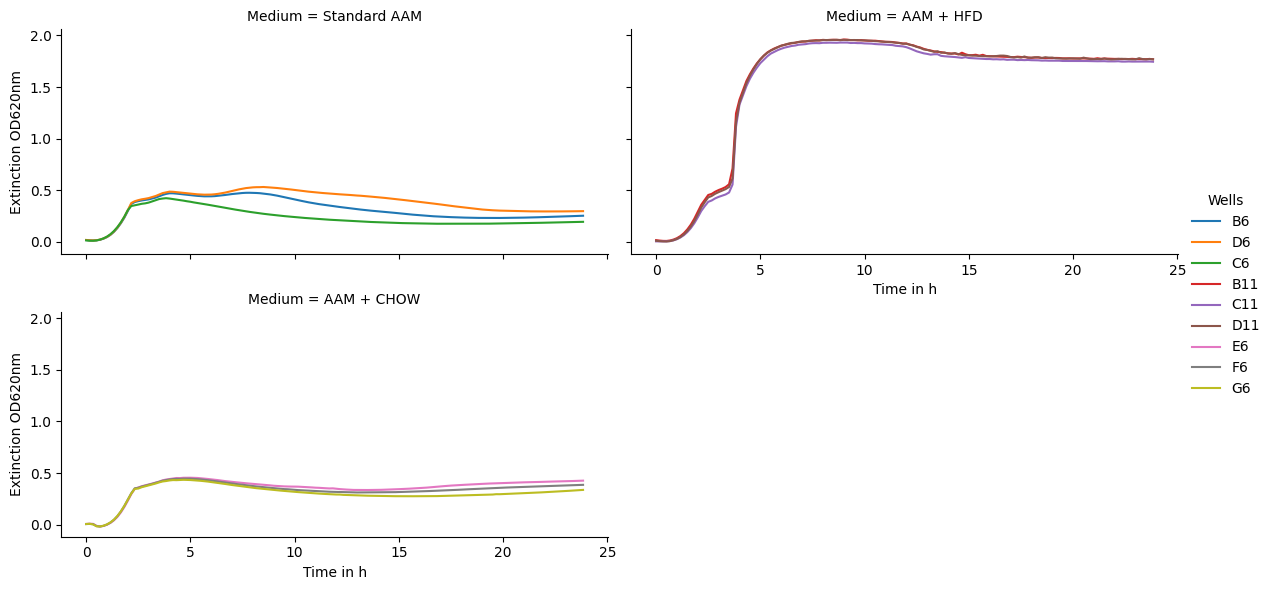

In [15]:
g = sns.FacetGrid(DF_sheet, col='Medium', hue='Wells', aspect=2, col_wrap=2)
g.map(sns.lineplot, 'Time in h', 'Extinction OD620nm')
g.add_legend()  # Add legend here
plt.show()